# 분류별/연도별 데이터 검정

## 라이브러리 선언

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import scipy as sp
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
year_list = ['2019', '2020', '2021']
start_list = ['08-01', '01-01', '01-01']
end_list = ['12-31', '12-31', '07-31']

## 배달 데이터 불러오기

In [3]:
from delivery.delivery_data import get_dataframe as get_delivery

delivery_list = []

for year, start, end in zip(year_list, start_list, end_list):
    delivery_list.append(get_delivery(year, start, end, 'delivery/original_data/'))

In [4]:
# delivery_list[2]

## 날씨 데이터 불러오기

In [5]:
from weather.weather_data import get_dataframe as get_weather

weather_list = []

for year, start, end in zip(year_list, start_list, end_list):
    weather_df = get_weather(year, start, end, 'weather/original_data/')
    del weather_df['cloud']
    del weather_df['snow']
    del weather_df['wind']

    # 배달 데이터에서 누락된 행 제거
    if year == '2020':
        weather_df = weather_df.drop('05-18')
    elif year == '2021':
        missing_values = ['03-27', '03-28', '03-29', '03-30', '03-31', '07-20', '07-21']
        for missing_value in missing_values:
            weather_df = weather_df.drop(missing_value)

    weather_list.append(weather_df)

In [6]:
# weather_list[2]

## 검정용 데이터 전처리

In [25]:
sunny_days, rainy_days = [], []
warm_days, hot_days, cold_days = [], [], []

for weather_df in weather_list:
    weather_df = weather_df.reset_index()
    sunny_days.append(weather_df[ weather_df['rain'] < 3.0 ]['date'].tolist())
    rainy_days.append(weather_df[ weather_df['rain'] >= 3.0 ]['date'].tolist())
    warm_days.append(weather_df[ (weather_df['temp'] <= 24.0) & (weather_df['temp'] >= 1.2) ]['date'].tolist())
    hot_days.append(weather_df[ weather_df['temp'] > 24.0 ]['date'].tolist())
    cold_days.append(weather_df[ weather_df['temp'] < 1.2 ]['date'].tolist())
    weather_df = weather_df.set_index('date')

In [33]:
sunny_list, rainy_list = [], []
warm_list, hot_list, cold_list = [], [], []

rain_zip = zip(delivery_list, sunny_days, rainy_days)
temp_zip = zip(delivery_list, warm_days, hot_days, cold_days)

for delivery_df, sunny_day, rainy_day in rain_zip:
    sunny_list.append(delivery_df.loc[sunny_day])
    rainy_list.append(delivery_df.loc[rainy_day])

for delivery_df, warm_day, hot_day, cold_day in temp_zip:
    warm_list.append(delivery_df.loc[warm_day])
    hot_list.append(delivery_df.loc[hot_day])
    cold_list.append(delivery_df.loc[cold_day])

In [29]:
categories = delivery_list[0].columns.tolist()[1:]

## 독립표본 검정 (강수량 차이에 따른 각 분류 별 주문횟수 변화)

In [58]:
ind_list = []

for sunny_df, rainy_df in zip(sunny_list, rainy_list):

    ind_dict = dict()

    for categorie in categories:
        pvalue = stats.ttest_ind(sunny_df[categorie], rainy_df[categorie])[1]
        ind_dict[categorie] = pvalue
    
    ind_list.append(ind_dict)

In [59]:
ind_df = delivery_list[0].copy().reset_index()
ind_df = ind_df.drop(range(len(ind_df)))
del ind_df['date']
del ind_df['sum']

for ind_dict, year in zip(ind_list, year_list):
    year_df = pd.DataFrame.from_dict(ind_dict, orient='index').T
    year_df = year_df.rename(index={0: year})
    ind_df = ind_df.append(year_df)

In [60]:
# rainy_day와 sunny_day의 독립표본 검정을 각 연도 별로 진행해 정리한 데이터프레임
ind_df

,bossam,bunsik,chicken,cnfood,dessert,dosirak,fastfood,jpfood,krfood,pizza,sashimi,simburum,tang,wsfood
2019,0.770048,0.480129,0.131037,0.659463,0.873215,0.755093,0.087979,0.919241,0.072020,0.754626,0.653096,0.025767,0.531666,0.072906
2020,0.068991,0.720703,0.199326,0.096771,0.632076,0.010914,0.199161,0.535646,0.099688,0.186300,0.230032,0.193901,0.471677,0.573757
2021,0.000713,0.000478,0.001295,0.000753,0.002635,0.001172,0.000112,0.009947,0.000490,0.000462,0.000349,0.247992,0.001700,0.000413


## 분산분석 (평균온도 차이에 따른 총주문횟수 변화)

In [113]:
oneway_dict = dict()

temp_df_zip = zip(warm_list, hot_list, cold_list, year_list)

for warm_df, hot_df, cold_df, year in temp_df_zip:
    anova1 = warm_df['sum'].values
    anova2 = hot_df['sum'].values
    anova3 = cold_df['sum'].values

    oneway_dict[year] = stats.f_oneway(anova1, anova2, anova3)[1]

In [114]:
oneway_dict

{'2019': 0.0007638970009574096,
 '2020': 0.0007412703696471888,
 '2021': 3.1123520716174593e-09}

## 카이제곱 검정 (연도 별 평균온도 차이에 따른 총주문횟수 변화)

In [103]:
contingency_df = pd.DataFrame(columns={'warm', 'hot', 'cold'})

temp_df_zip = zip(warm_list, hot_list, cold_list, year_list)

for warm_df, hot_df, cold_df, year in temp_df_zip:
    warm_mean = np.mean(warm_df['sum']).round(2)
    hot_mean = np.mean(hot_df['sum']).round(2)
    cold_mean = np.mean(cold_df['sum']).round(2)
    temp_dict = {year: {'warm': warm_mean, 'hot': hot_mean, 'cold': cold_mean}}

    year_df = pd.DataFrame.from_dict(temp_dict, orient='index')

    contingency_df = contingency_df.append(year_df)

In [109]:
contingency_df

,warm,cold,hot
2019,5301.12,5359.94,4314.7
2020,5808.78,6810.78,5889.81
2021,3609.78,5857.69,2792.89


In [111]:
stats.chi2_contingency([contingency_df['warm'], contingency_df['cold']])[1]

5.268166934237604e-62

## 테스트 코드

In [ ]:
delivery_test = delivery_list[0].copy()
delivery_test = delivery_test.drop(range(len(delivery_test)))
del delivery_test['date']
delivery_test

,sum,bossam,bunsik,chicken,cnfood,dessert,dosirak,fastfood,jpfood,krfood,pizza,sashimi,simburum,tang,wsfood


In [ ]:
# delivery_test = delivery_test.append(delivery[ delivery['date'].isin(rainy_day) ].mean().round().rename('rainy'))
# delivery_test

In [ ]:
# test = test.append(delivery[ ~(delivery['date'].isin(rainy_day)) ].mean().round().rename('sunny'))
# test

In [ ]:
rainy_chicken = rainy_df['chicken'].tolist()
sunny_chicken = sunny_df.loc[range(len(rainy_df))]['chicken'].tolist()

chicken_df = pd.DataFrame({'rainy':rainy_chicken, 'sunny':sunny_chicken})

<AxesSubplot:xlabel='chicken'>

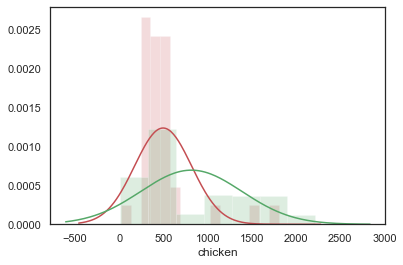

In [ ]:
sns.distplot(rainy_df['chicken'], kde=False, fit=stats.norm,
            hist_kws={'color': 'r', 'alpha': 0.2}, fit_kws={'color': 'r'})

sns.distplot(sunny_df['chicken'], kde=False, fit=stats.norm, 
             hist_kws={'color': 'g', 'alpha': 0.2}, fit_kws={'color': 'g'})

In [ ]:
anova1 = warm_df['chicken'].values
anova2 = hot_df['chicken'].values
anova3 = cold_df['chicken'].values
stats.f_oneway(anova1, anova2, anova3)

F_onewayResult(statistic=6.882339385540798, pvalue=0.0013814227517537291)

<AxesSubplot:>

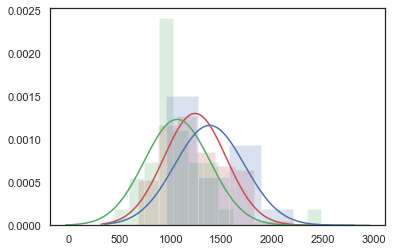

In [ ]:
sns.distplot(anova1, kde=False, fit=sp.stats.norm, hist_kws={'color': 'r', 'alpha': 0.2}, fit_kws={'color': 'r'})
sns.distplot(anova2, kde=False, fit=sp.stats.norm, hist_kws={'color': 'g', 'alpha': 0.2}, fit_kws={'color': 'g'})
sns.distplot(anova3, kde=False, fit=sp.stats.norm, hist_kws={'color': 'b', 'alpha': 0.2}, fit_kws={'color': 'b'})